<img src=https://40.68.82.247:8000/user/laketide/files/DevSum17/julialang.png/>

# Julia Types

* Julia is dynamically typed - with some advantages from statically typed languages
* Default behavior has omitted types and allows values to be of any type
* Explicit type annotation is convenient to speed up performance and make code robust
* Concrete types are final - only abstract types as supertypes
* Abstract types can not be instantiated - connects node in the type graph

## Composite types

In [ ]:
type Foo            
  bar 
  baz::Int 
  qux::Float64        
end

In [ ]:
foo = Foo("Hello, world.", 23, 1.5)

In [ ]:
typeof(foo)

In [ ]:
type NoFields 
end

In [ ]:
is(NoFields(), NoFields())

# Immutable Objects

In [ ]:
abstract MyType 

type MyType1 <: MyType     
  i::Int     
  b::Bool     
  f::Float64 
end 

immutable MyType2 <: MyType     
  i::Int     
  b::Bool     
  f::Float64 
end

In [ ]:
@time x=[MyType1(i,1,1) for i=1:100];
@time x=[MyType2(i,1,1) for i=1:100];

# Multiple Dispatch

In [ ]:
f(a::Any, b) = "fallback"
f(a::Number, b::Number) = "a and b are both numbers"
f(a::Number, b) = "a is a number"
f(a, b::Number) = "b is a number"
f(a::Integer, b::Integer) = "a and b are both integers"

In [ ]:
f(1.5,2)

In [ ]:
f(1,"bar")

In [ ]:
f(1,2)

In [ ]:
f("foo",[1,2])

## "Diagonal dispatch"

In [ ]:
f{T<:Number}(a::T, b::T) = "a and b are both $(T)s"

In [ ]:
f(big(1.5),big(2.5))

In [ ]:
f(big(1),big(2)) #<== integer rule is more specific

## Methods using varargs 

In [ ]:
f(args::Number...) = "$(length(args))-ary heterogeneous call"
f{T<:Number}(args::T...) = "$(length(args))-ary homogeneous call"

In [ ]:
f(1,2,3)

In [ ]:
f(1,1.5,2)

In [ ]:
f(1,2) #<== previous 2-arg method is more specific

In [ ]:
f() #Why not homogeneous?

# Metaprogramming

In [ ]:
funnyprogram = "1 + 1 / 2"

In [ ]:
ex1 = parse(funnyprogram)

In [ ]:
typeof(ex1)

In [ ]:
dump(ex1)

In [ ]:
eval(ex1)

In [ ]:
macro istrue(x)
    return :( $x ? 1 : 0)
end

In [ ]:
@istrue 1 == 2

In [ ]:
a = :(@istrue 1 == 2)

In [ ]:
typeof(a)

In [ ]:
macroexpand(a)

In [ ]:
function func_lo(n::Int)
    a = "lo"
    for i=1:n
        print(a)
        # ccall(:cfunc, retType, (argType1, argType2), arg1, arg2)
    end
end

In [ ]:
func_lo(32)

In [ ]:
@eval function $(:func_lo)()
    print("trollolollo")
end

In [ ]:
func_lo()

In [ ]:
func_lo(2)

In [ ]:
for sym in [:lo, :ke, :ha]
    @eval function $(Symbol(string("func_",sym)))(n::Int)
              for i=1:n
                  print($(string(sym)))
              end
          end
end

In [ ]:
func_ke(24)

In [ ]:
using ProgressMeter

In [ ]:
@showprogress for i in 1:100
    sleep(0.1)
end

In [ ]:
macroexpand(:(@time sleep(1)))

# Performance

## $$f_c(z) = z^2 + c$$

In [ ]:
using Colors
using Images
using BenchmarkTools

In [ ]:
detail = 150
h = 500
w = 500
bitmap = Array(Gray24, h, w)
c = (φ-2) + (φ-1)im

In [ ]:
π

In [ ]:
function fractal(z, c, max)
    for i in 1 : max
        (abs(z) > 2) ? (return i) : (z = z^2 + c)        
    end
    return max
end

In [ ]:
tic()
for x in 1:w, y in 1:h
    z = (3*(x-w/2)/w) + (3*(y-h/2)/h)im
    out = fractal(z, c, detail)
    bitmap[y,x] = Gray24(out/detail)
end
toc()

In [ ]:
convert(ImageMeta,bitmap)

In [ ]:
function plus(a,b)
    return a+b
end

In [ ]:
@code_native plus(1,1)

In [ ]:
@code_native plus(1.0,1)

In [ ]:
detail = 1000
h = 3000
w = 3000
bitmap = Array(Gray24, h, w)
c = (φ-2) + (φ-1)im

In [ ]:
function fractal(z::Complex, c::Complex, max::Int)
    @simd @fastmath for i in 1 : max
        (abs(z) > 2) ? (return i) : (z = z^2 + c)        
    end
    return max
end

In [ ]:
function generate(w::Int, h::Int, c::Complex, detail::Int)
    for x in 1:w, y in 1:h
        z = (3*(x-w/2)/w) + (3*(y-h/2)/h)im #bad from Int to Float
        out = fractal(z, c, detail)
        bitmap[y,x] = Gray24(out/detail)
    end
    return bitmap
end

In [ ]:
tic()
generate(w, h, c, detail)
toc()

# Parallelism

In [ ]:
function generate(w::Int, h::Int, c::Complex, detail::Int)
    Threads.@threads for x in 1:w
        for y in 1:h
            z = (3*(x-w/2)/w) + (3*(y-h/2)/h)im #bad from Int to Float
            out = fractal(z, c, detail)
            bitmap[y,x] = Gray24(out/detail)
        end
    end
    return bitmap
end

In [ ]:
@benchmark generate(w, h, c, detail)

In [ ]:
procs()

In [ ]:
addprocs(192.1)

In [ ]:
a = remotecall(sin, 2, rand(3000,3000))

In [ ]:
wait(a)

In [ ]:
fetch(a)

In [ ]:
function serial_add()
    s=0.0       
    for i = 1:1000000         
        s=s+randn()      
    end       
    return s    
end

In [ ]:
function parallel_add()
    return @parallel (+) for i=1:1000000
        randn()
    end
end

In [ ]:
@benchmark serial_add()

In [ ]:
@benchmark parallel_add()

# Arrayfire.jl
AFArray <: AbstractArray 

* Easy gpu computing in julia 
* Wraps arrayfire library 
* Mimic base julia in design

In [ ]:
using ArrayFire
setBackend(AF_BACKEND_CUDA)

In [ ]:
getActiveBackend()

## Create CPU julia array

In [ ]:
a = randn(10,10)

## Transfer to GPU

In [ ]:
ad = AFArray(a)

### Note, only able to see the array on the GPU because in interactive programming there is an implicit memory transfer from device to host. Only shown for REPL and won't happen in script. Real applications won't perform this unnecessary transfers. 

## Benchmarks

In [ ]:
function matmul(a::AFArray, b::AFArray)
    for i = 1:10
        r = a * b
        ArrayFire.eval(r)
    end
    sync(0)
end

function fast_fourier(a::AFArray)
    for i = 1:10
        r = fft(a)
        ArrayFire.eval(r)
    end
    sync(0)
end

In [ ]:
a = rand(Float32, 2000, 2000); 
ad = AFArray(a);

In [ ]:
#Matmul
info("Matmul")
t1 = @elapsed a * a
t2 = @elapsed matmul(ad, ad)
println("Time (CPU): $t1") 
println("Time (GPU): $(t2/10)") 
gc()

#FFT
info("FFT")
t1 = @elapsed fft(a)
t2 = @elapsed fast_fourier(ad)
println("Time (CPU): $t1") 
println("Time (GPU): $(t2/10)") 

## Blackscholes example - Multiple Dispatch

In [ ]:
function blackscholes_serial(sptprice::AbstractArray{Float32},
                           strike::AbstractArray{Float32},
                           rate::AbstractArray{Float32},
                           volatility::AbstractArray{Float32},
                           time::AbstractArray{Float32})
    logterm = log10( sptprice ./ strike)
    powterm = .5f0 .* volatility .* volatility
    den = volatility .* sqrt(time)
    d1 = (((rate .+ powterm) .* time) .+ logterm) ./ den
    d2 = d1 .- den
    NofXd1 = cndf2(d1)
    NofXd2 = cndf2(d2)
    futureValue = strike .* exp(- rate .* time)
    c1 = futureValue .* NofXd2
    call_ = sptprice .* NofXd1 .- c1
    put  = call_ .- futureValue .+ sptprice
end

In [ ]:
@inline function cndf2(in::AbstractArray{Float32})
    out = 0.5f0 .+ 0.5f0 .* erf(0.707106781f0 .* in)
    return out
end

In [ ]:
import Base.run
function run(iterations)
    sptprice   = Float32[ 42.0 for i = 1:iterations ]
    initStrike = Float32[ 40.0 + (i / iterations) for i = 1:iterations ]
    rate       = Float32[ 0.5 for i = 1:iterations ]
    volatility = Float32[ 0.2 for i = 1:iterations ]
    time       = Float32[ 0.5 for i = 1:iterations ]

    sptprice_gpu = AFArray(sptprice)
    initStrike_gpu = AFArray(initStrike)
    rate_gpu = AFArray(rate)
    volatility_gpu = AFArray(volatility)
    time_gpu = AFArray(time)

    tic()
    put1 = blackscholes_serial(sptprice, initStrike, rate, volatility, time)
    t1 = toq()
    println("Serial checksum: ", sum(put1))
    tic()
    put2 = blackscholes_serial(sptprice_gpu, initStrike_gpu, rate_gpu, volatility_gpu, time_gpu)
    t2 = toq()
    println("Parallel checksum: ", sum(put2))
    return t1, t2
end

In [ ]:
function driver()
    srand(0)
    tic()
    iterations = 10^6
    blackscholes_serial(Float32[], Float32[], Float32[], Float32[], Float32[])
    blackscholes_serial(AFArray(Float32[1., 2.]), AFArray(Float32[1., 2.]), 
                        AFArray(Float32[1., 2.]), AFArray(Float32[1., 2.]), AFArray(Float32[1., 2.]))
    println("SELFPRIMED ", toq())
    tserial, tparallel = run(iterations)
    println("Time taken for CPU = $tserial")
    println("Time taken for GPU = $tparallel")
    println("Speedup = $(tserial / tparallel)")
    println("CPU rate = ", Int(floor(iterations / tserial)), " opts/sec")
    println("GPU rate = ", Int(floor(iterations / tparallel)), " opts/sec")
end

In [ ]:
driver()

# Deep learning - Image recognition with MXNet

![title](microsoft/nn.jpeg)

![title](microsoft/cnn.jpeg)

## Data pre-processing
- Scaling
- Normalization
- Labeling

In [7]:
using DataFrames
using FileIO
using Images

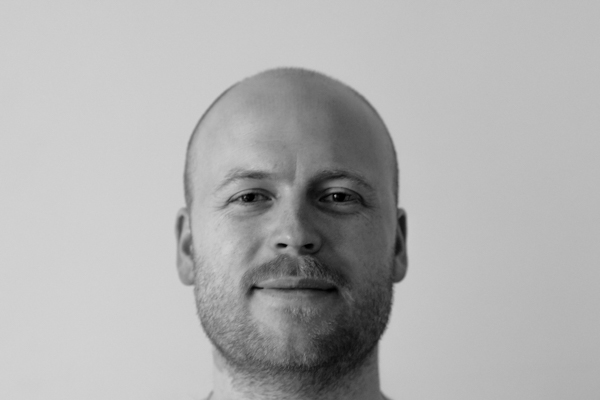

In [8]:
raw = load(string("./microsoft/datatide4/petter_00002.jpg"))

In [9]:
#A = float(rawview(channelview(temp))) # Use to go between float matrices and pictures
imageFolder = "./microsoft/datatide4/"
filenames = map(x -> replace(x, ".jpg", ""), readdir(imageFolder))
labels = map(x -> split(x, "_")[1], filenames)
classes = unique(labels)
classDict = Dict(classes[i] => (i-1) for i=1:length(classes))
labelSize = 1
width = 75
heigth = 75

data = zeros(Float32, heigth, width, length(filenames))
label = zeros(Int64, length(filenames))

for i in 1:length(filenames)
    image = load(string("microsoft/datatide4/", filenames[i], ".jpg"))
    image_resized = imresize(image, heigth, width)
    temp = convert(Array{Float32}, image_resized)
    data[ :, :, i] = temp 
    label[i] = classDict[labels[i]]
end

### Preprocessed input data

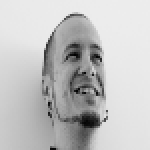

In [10]:
colorview(Gray,data[:,:,100])

### Create a MXNet data provider from the data

In [11]:
using MXNet

In [12]:
mxData = mx.Variable(:data)
mxLabel  = mx.Variable(:softmax_label)

batch_size = 5

train_provider = mx.ArrayDataProvider(:data => reshape(data, (heigth,width,1,length(filenames))),
    :softmax_label => label,
    batch_size=batch_size, 
    shuffle=true)


MXNet.mx.ArrayDataProvider(Array[
Float32[0.905882 0.878431 … 0.768628 0.862745; 0.901961 0.878431 … 0.780392 0.854902; … ; 0.905882 0.909804 … 0.0 0.898039; 0.905882 0.905882 … 0.0 0.909804]],Symbol[:data],Array[
Float32[0.0 0.0 … 5.0 5.0]],Symbol[:softmax_label],5,108,true,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(75,75,1,5)],MXNet.mx.NDArray[mx.NDArray{Float32}(5,)])

# Create CNN architecture
- kernel
- filters
- pooling
- stride

In [13]:
conv1 = @mx.chain mx.Convolution(mxData, kernel=(3,3), num_filter=150)  =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Pooling(pool_type=:max, kernel=(3,3), stride=(2,2))

conv2 = @mx.chain mx.Convolution(conv1, kernel=(5,5), num_filter=150) =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(1,1))

conv3 = @mx.chain mx.Convolution(conv2, kernel=(3,3), num_filter=150) =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))

conv4 = @mx.chain mx.Convolution(conv3, kernel=(3,3), num_filter=100) =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Pooling(pool_type=:max, kernel=(2,2), stride=(2,2))

fc1   = @mx.chain mx.Flatten(conv4) =>
                  mx.FullyConnected(num_hidden=400) =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Dropout(p=0.2)

fc2   = @mx.chain mx.FullyConnected(fc1, num_hidden=400) =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Dropout(p=0.2)

fc3   = @mx.chain mx.FullyConnected(fc2, num_hidden=400) =>
                  mx.BatchNorm() =>
                  mx.Activation(act_type=:relu) =>
                  mx.Dropout(p=0.2)

fc4   = mx.FullyConnected(fc3, num_hidden=length(classes)) 

mlp  = mx.SoftmaxOutput(fc4, name=:softmax)


MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x00000000092124a0))

# Create model, define optimizer, run model

In [14]:
const learning_rate = 0.005
const momentum = 0.90
const l2 = 0 # set to zero if dropout is used

# Define model and its hardware context
model = mx.FeedForward(mlp,context=mx.gpu())

# Define an optimizer to train the network
optimizer = mx.ADAM(lr = learning_rate, weight_decay=l2)

MXNet.mx.ADAM(MXNet.mx.ADAMOptions(0.005,0,0,0.9,0.999,1.0e-8,MXNet.mx.LearningRate.Fixed(0.005)),#undef)

In [15]:
const epochs = 80

mx.fit(model,
    optimizer, 
    train_provider,
    eval_metric=mx.Accuracy(),
    n_epoch=epochs, 
    callbacks=[mx.speedometer(frequency=20)]
    )

INFO: Start training on MXNet.mx.Context[GPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
[14:11:42] src/operator/././cudnn_algoreg-inl.h:57: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
INFO: TempSpace: Total 86 MB allocated on GPU0
INFO: Start training...
INFO: Speed:  29.55 samples/sec
INFO: == Epoch 001/080 ==========
INFO: ## Training summary
INFO:           accuracy = 0.3091
INFO:               time = 3.9240 seconds
INFO: Speed: 189.95 samples/sec
INFO: == Epoch 002/080 ==========
INFO: ## Training summary
INFO:           accuracy = 0.5273
INFO:               time = 0.6013 seconds
INFO: Speed: 202.13 samples/sec
INFO: == Epoch 003/080 ==========
INFO: ## Training summary
INFO:           accuracy = 0.5455
INFO:               time = 0.5510 seconds
INFO: Speed: 229.40 samples/sec
INFO: == Epoch 004/080 ==========
INFO: ## Training summary
INFO:           

# Lets see some results

In [18]:
e_data = zeros(Float32, heigth, width, 1) 
e_label = zeros(Int64, 1)

#image = load(string("./microsoft/eval/petter_00001.jpg"))
image = load(string("./microsoft/eval/arnold_0001.jpg"))
image_resized = imresize(image, heigth, width)
temp = convert(Array{Float32}, image_resized)
e_data[:,:,1] = temp 

eval_provider = mx.ArrayDataProvider(:data => reshape(e_data, (heigth,width,1,1)),
    batch_size=1);

Probabilities:

    Alejandro: 0 %

    Carlos: 0 %

    Diantha: 0 %

    Peter: 0 %

    Petter: 1 %

    Robert: 97 %


INFO: TempSpace: Total 6 MB allocated on GPU0


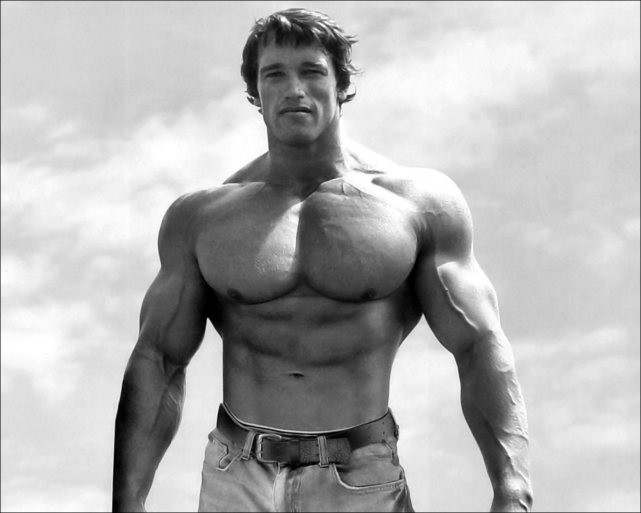

In [19]:
probs = mx.predict(model, eval_provider)
alex = Int(floor(probs[1]*100))
carlos = Int(floor(probs[2]*100))
diant = Int(floor(probs[3]*100))
peter = Int(floor(probs[4]*100))
petter = Int(floor(probs[5]*100))
robert = Int(floor(probs[6]*100))
println("Probabilities:\n
    Alejandro: $alex %\n
    Carlos: $carlos %\n
    Diantha: $diant %\n
    Peter: $peter %\n
    Petter: $petter %\n
    Robert: $robert %")
image